<a href="https://colab.research.google.com/github/vaishhhx/Machine-Learning/blob/main/Spam_Email_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
cd /content/drive/My Drive/Dataset

/content/drive/My Drive/Dataset


In [81]:
# Read dataset from drive
data = pd.read_csv("spam emails.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [82]:
data.Category.value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [83]:
data['spam'] = data['Category'].apply(lambda x: 1 if x =='spam' else 0)

In [84]:
data.shape

(5572, 3)

In [85]:
data.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [86]:
data=data.drop(['Category'],axis=1)

In [87]:
data.shape

(5572, 2)

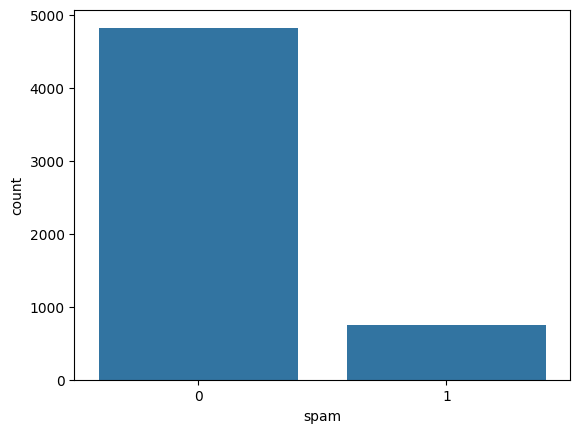

In [88]:
sns.countplot(x='spam', data=data)
plt.show()

Text(0.5, 0, 'Message types')

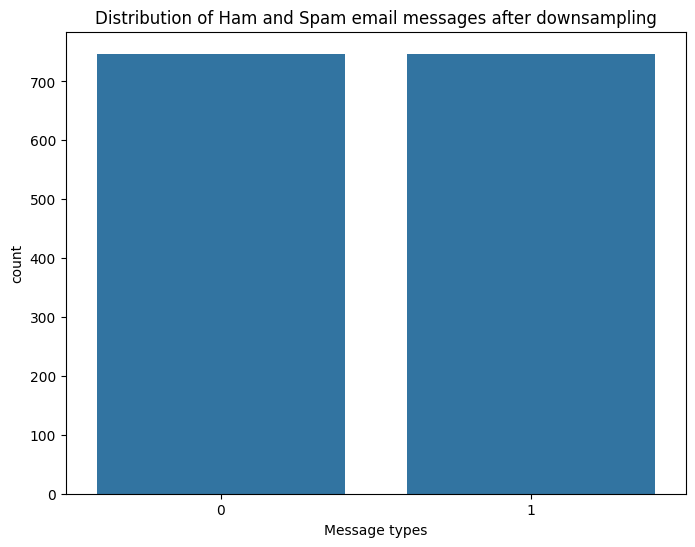

In [68]:
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combining ham and spam messages
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)

# Plotting the counts of the downsampled dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [69]:
balanced_data.head()

,Message,spam
0,If i not meeting ü all rite then i'll go home ...,0
1,"I.ll always be there, even if its just in spir...",0
2,"Sorry that took so long, omw now",0
3,I thk 50 shd be ok he said plus minus 10.. Did...,0
4,Dunno i juz askin cos i got a card got 20% off...,0


In [89]:
def remove_stopwords(Message):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(Message).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


data['Message'] = data['Message'].apply(lambda Message: remove_stopwords(Message))
data.head()

,Message,spam
0,"go jurong point, crazy.. available bugis n gre...",0
1,ok lar... joking wif u oni...,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun say early hor... u c already say...,0
4,"nah think goes usf, lives around though",0


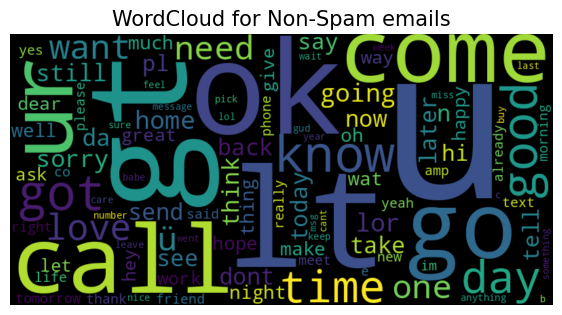

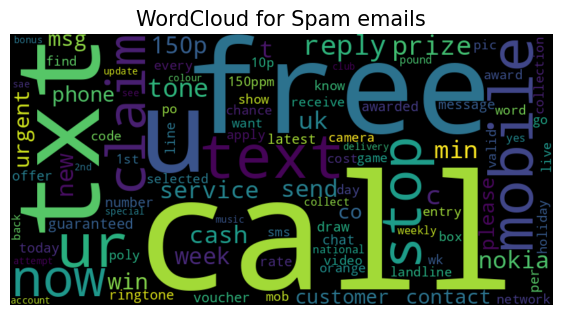

In [90]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['Message'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(data[data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(data[data['spam'] == 1], typ='Spam')

In [91]:
# Train test split

train_X, test_X, train_Y, test_Y = train_test_split(data['Message'], data['spam'], test_size = 0.2, random_state = 42)

In [92]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')

In [93]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [94]:
# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           253344    
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 257057 (1004.13 KB)
Trainable params: 257057 (1004.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'], optimizer = 'adam')

In [96]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)

In [97]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=50,
					batch_size=5,
          callbacks = [lr, es]
				)

Epoch 1/50
892/892 [==============================] - 35s 37ms/step - loss: 0.4048 - accuracy: 0.8647 - val_loss: 0.3965 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 2/50
892/892 [==============================] - 33s 37ms/step - loss: 0.3964 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 3/50
892/892 [==============================] - 31s 35ms/step - loss: 0.3959 - accuracy: 0.8658 - val_loss: 0.3934 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 4/50
892/892 [==============================] - 32s 36ms/step - loss: 0.3954 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664 - lr: 0.0010


In [98]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

35/35 [==============================] - 1s 9ms/step - loss: 0.3964 - accuracy: 0.8664
Test Loss : 0.39644941687583923
Test Accuracy : 0.8663676977157593


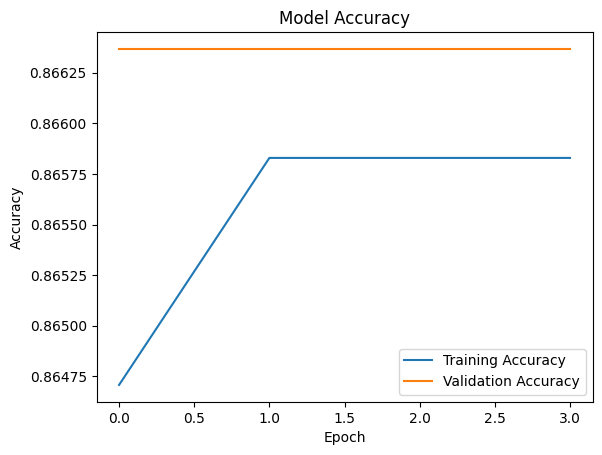

In [99]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()